In [41]:
%run functions.ipynb

np.set_printoptions(precision=3)
np.random.seed(42)

%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/pio/scratch/1/i272955/anaconda3/envs/master/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['std', 'axes']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
labels = load_file('data/labels_for_microarray_data.csv')
dataset = load_file('data/microarray_data.csv')[:, 1:].T
print(labels.shape, dataset.shape)
X_train, X_test, y_train, y_test = load_train_and_test_parts()
print("Train and test sizes: {} {}".format(X_train.shape, X_test.shape))
print("(1, 0) labels count in train test: {} {}".format((np.count_nonzero(y_train==1), np.count_nonzero(y_train==0)), 
                                                        (np.count_nonzero(y_test==1), np.count_nonzero(y_test==0))))
standarizer = StandardScaler().fit(X_train)
X_std_train = standarizer.transform(X_train)
X_std_test = standarizer.transform(X_test)

(969,) (969, 12179)
Train and test sizes: (726, 12179) (243, 12179)
(1, 0) labels count in train test: (289, 437) (104, 139)


# Basic classifiers on raw data

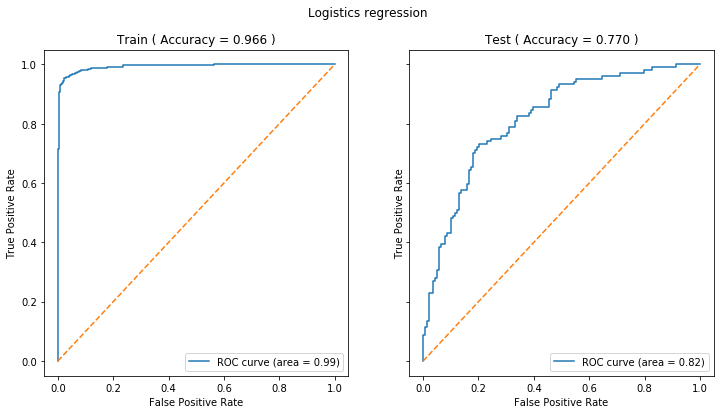

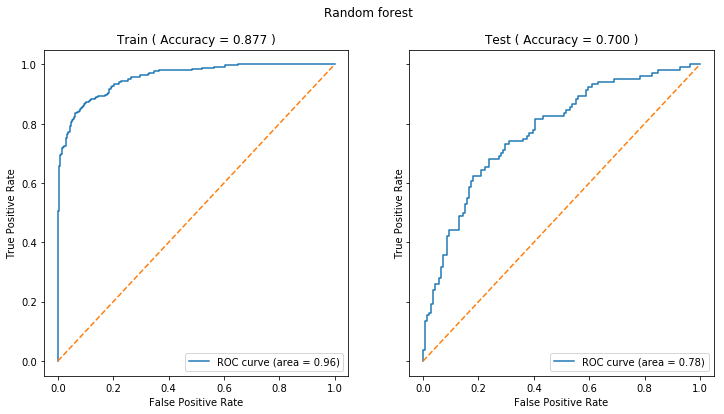

In [3]:
(clf_logit, clf_forest) = fit_models(X_train, y_train, X_test, y_test)

# Basic classifiers on standarized data

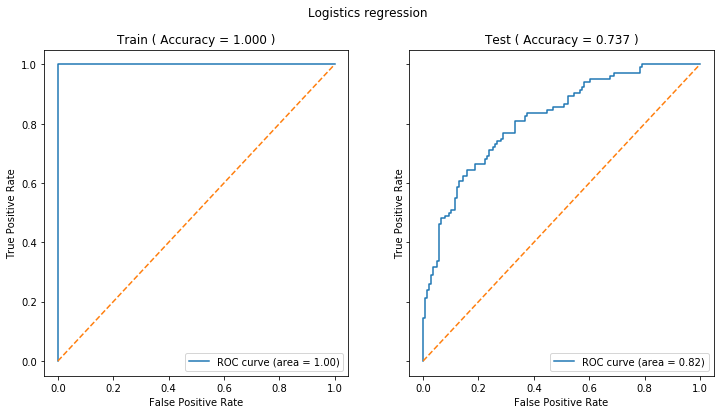

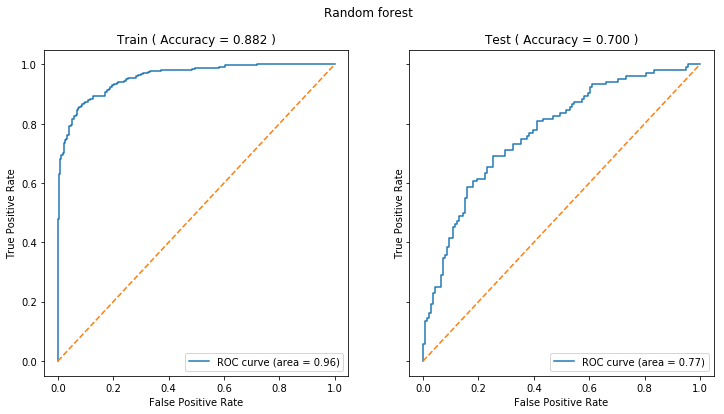

In [4]:
(clf_logit, clf_forest) = fit_models(X_std_train, y_train, X_std_test, y_test)

# Data statistics

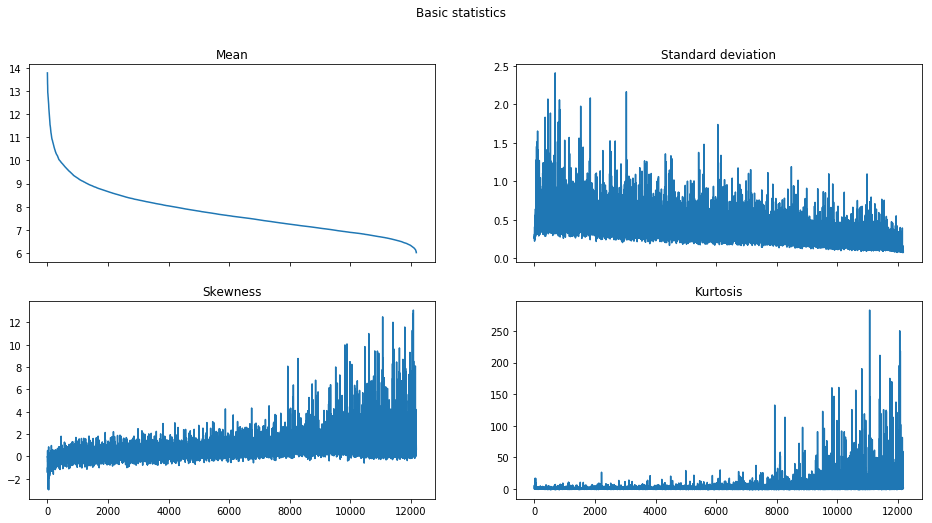

In [20]:
from scipy.stats import skew, kurtosis

def compute_basic_statistics(dataset):
    p = dataset.shape[1]
    means = np.mean(dataset, axis=0)
    stds = np.std(dataset, axis=0)
    skews = skew(dataset, axis=0)
    kurtoses = kurtosis(dataset, axis=0)

    fig, axes = plt.subplots(nrows = 2, ncols=2, figsize = (16,8), sharex=True)
    fig.suptitle("Basic statistics")
    (ax1, ax2, ax3, ax4) = np.array(axes).flatten()
    ax1.plot(np.arange(p), means)
    ax1.set_title("Mean")
    ax2.plot(np.arange(p), stds)
    ax2.set_title("Standard deviation")
    ax3.plot(np.arange(p), skews)
    ax3.set_title("Skewness")
    ax4.plot(np.arange(p), kurtoses)
    ax4.set_title("Kurtosis")
    plt.show()
    
    return p, means, stds, skews, kurtoses

p, means, std, skews, kurtoses = compute_basic_statistics(dataset)

Indices of genes with maximum skewness and kutosis respectively: 12080 11067


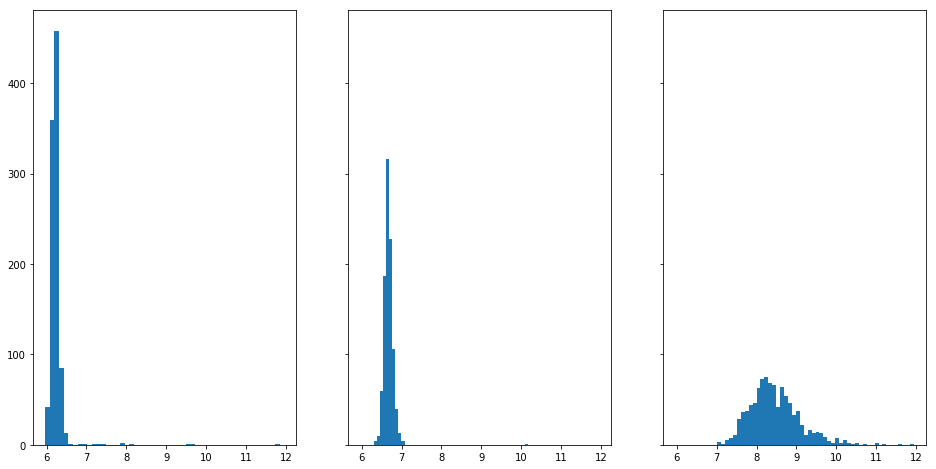

In [21]:
skewness_max_index = np.argmax(skews)
kurtosis_max_index = np.argmax(kurtoses)

print('Indices of genes with maximum skewness and kutosis respectively: {} {}'.format(skewness_max_index, kurtosis_max_index))
bins = 50

fig, axes = plt.subplots(nrows = 1, ncols=3, figsize = (16,8), sharey=True, sharex=True)
(ax1, ax2, ax3) = np.array(axes).flatten()
ax1.hist(dataset[:, skewness_max_index], bins=bins)
ax2.hist(dataset[:, kurtosis_max_index], bins=bins)
ax3.hist(dataset[:, 2500], bins=bins)
plt.show()

Checks connected with skewness and kurtosis:

* how many variables have skew, kurtosis above certain threshold - it appears that not many, in fact the variable indices for this staistics are almost the same - it may be therefore valid to try to get rid of these variables at all
* how many patients have values of one of the genes in this outlying region exceeding 99%-quantile for this value - unfortunately, it turns out that almost all

In [7]:
kurt_quant = np.quantile(kurtoses, [0.95, 0.99])
skew_quant = np.quantile(skews, [0.95, 0.99])
print("Skewness quatiles: q_95 = {:.3f}, q_99 = {:.3f}".format(*skew_quant))
print("Kurtosis quatiles: q_95 = {:.3f}, q_99 = {:.3f}".format(*kurt_quant))

quant = {0.95: 0, 0.99: 1}
threshold_skew = skew_quant[quant[0.95]]
threshold_kurt = kurt_quant[quant[0.95]]
nonnormal_indices = [
    x for x in np.arange(p) if kurtoses[x] > threshold_kurt or skews[x] > threshold_skew
]
indices_skew = [x for x in np.arange(p) if skews[x] > threshold_skew]
indices_kurt = [x for x in np.arange(p) if kurtoses[x] > threshold_kurt]

print("Number of genes with outlying skewness or kutosis: {}".format(len(nonnormal_indices)))
print("Number of genes ")


quantiles = [np.quantile(dataset[:, j], 0.99) for j in nonnormal_indices]

patients_indices = []
for i in np.arange(dataset.shape[0]):
    for idx, j in enumerate(nonnormal_indices):
        if dataset[i, j] > quantiles[idx]:
            patients_indices += [i]

patients_indices = np.unique(patients_indices)
print(
    "Number of patients with at least one extreme value of some outlying gene: {}".format(
        len(patients_indices)
    )
)

Skewness quatiles: q_95 = 2.149, q_99 = 4.932
Kurtosis quatiles: q_95 = 9.770, q_99 = 46.426
Number of genes with outlying skewness or kutosis: 710
Number of genes 
Number of patients with at least one extreme value of some outlying gene: 907


# Comparison of how models behave when discarding outlying variables:

* on all the rest of the varibales it is a little worse
* when we consder only these outlying variables we get significantly worse results
* when we consider 2 random subsets of variables of the same size as number of discarded variables we get results a little bit worse than in the first case and a little better than in the second case

In [8]:
dataset_95 = dataset[:, [x for x in np.arange(p) if x not in nonnormal_indices]]
dataset_05 = dataset[:, [x for x in np.arange(p) if x in nonnormal_indices]]
dataset_random1 = dataset[:, np.random.choice(np.arange(p), size = dataset_05.shape[1], replace=False)]
dataset_random2 = dataset[:, np.random.choice(np.arange(p), size = dataset_05.shape[1], replace=False)]

Train and test sizes: (726, 11469) (243, 11469)
(1, 0) labels count in train test: (300, 426) (93, 150)


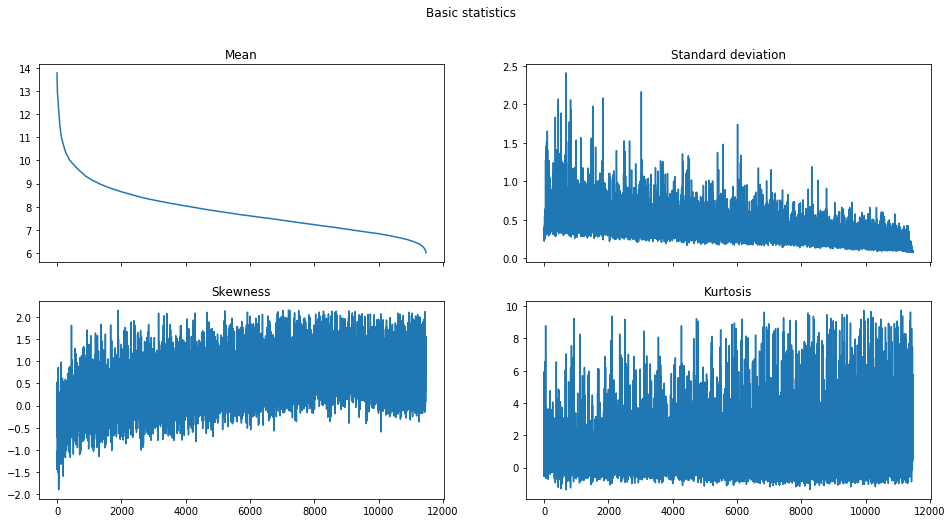

No normalization


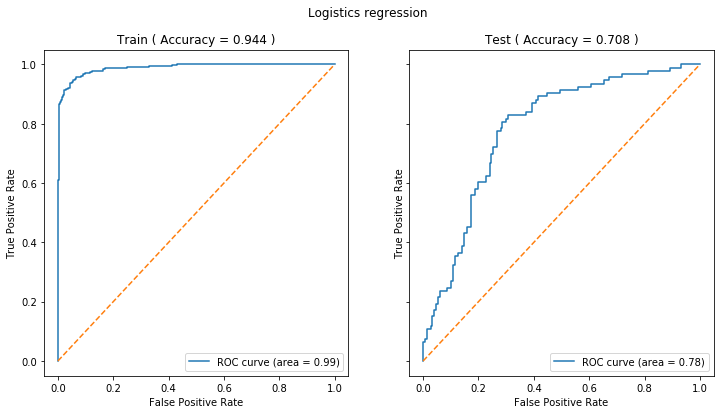

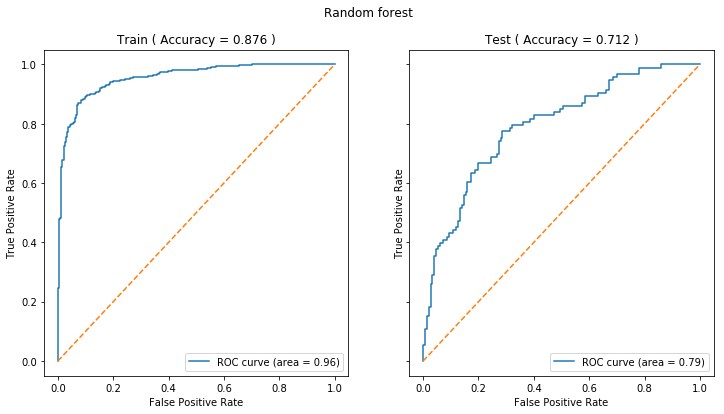

In [9]:
def basic_insight(dataset):
    X_train, X_test, y_train, y_test = train_test_split(dataset, labels, test_size=0.25, shuffle = True)
    print("Train and test sizes: {} {}".format(X_train.shape, X_test.shape))
    print("(1, 0) labels count in train test: {} {}".format((np.count_nonzero(y_train==1), np.count_nonzero(y_train==0)), 
                                                            (np.count_nonzero(y_test==1), np.count_nonzero(y_test==0))))

    standarizer = StandardScaler().fit(X_train)
    X_std_train = standarizer.transform(X_train)
    X_std_test = standarizer.transform(X_test)
    p, means, std, skews, curtoses = compute_basic_statistics(dataset)
    print("No normalization")
    (clf_logit, clf_forest) = fit_models(X_train, y_train, X_test, y_test)
    #print("After standarization")
    #(clf_logit, clf_forest) = fit_models(X_std_train, y_train, X_std_test, y_test)
    
basic_insight(dataset_95)

Train and test sizes: (726, 710) (243, 710)
(1, 0) labels count in train test: (307, 419) (86, 157)


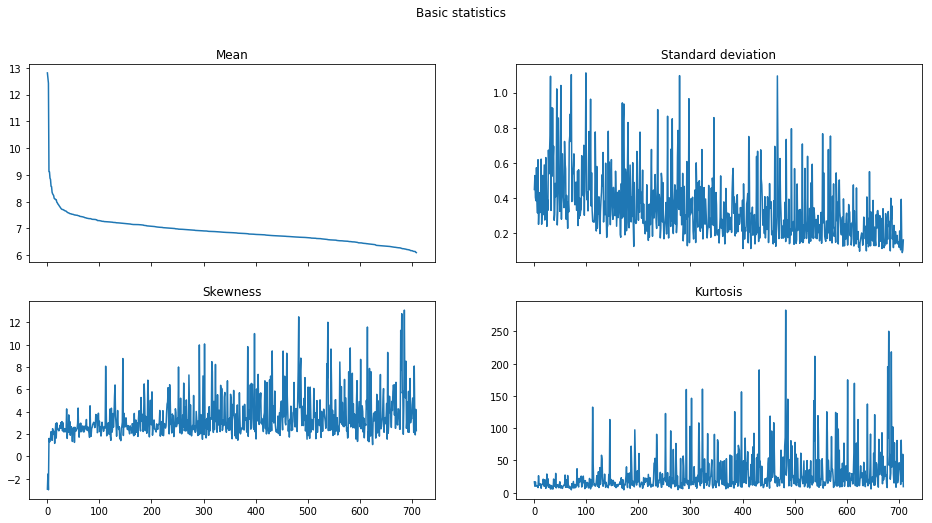

No normalization


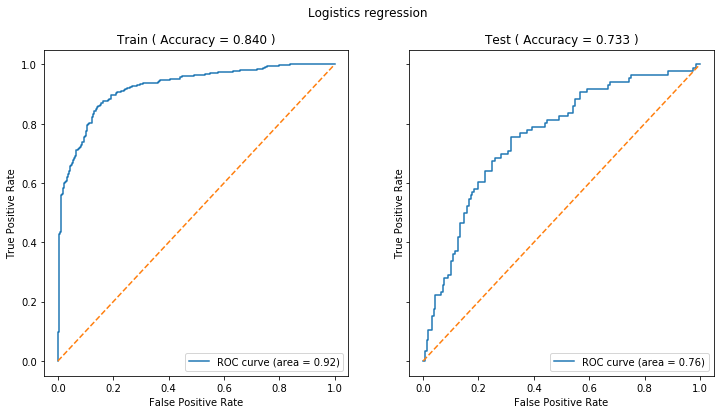

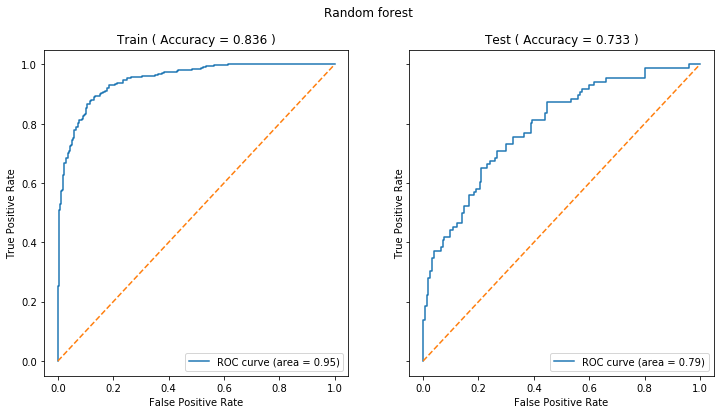

In [10]:
basic_insight(dataset_05)

Train and test sizes: (726, 710) (243, 710)
(1, 0) labels count in train test: (306, 420) (87, 156)


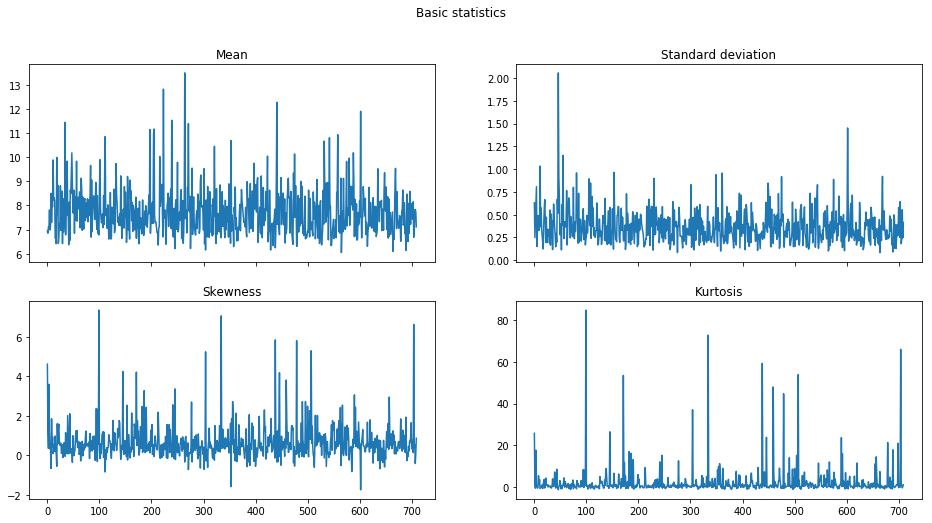

No normalization


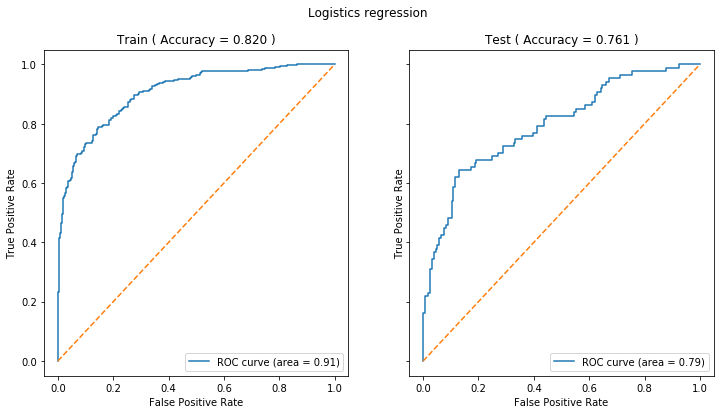

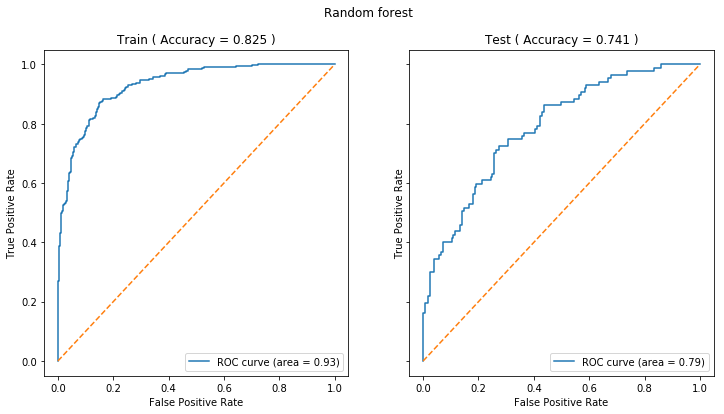

In [11]:
basic_insight(dataset_random1)

Train and test sizes: (726, 710) (243, 710)
(1, 0) labels count in train test: (289, 437) (104, 139)


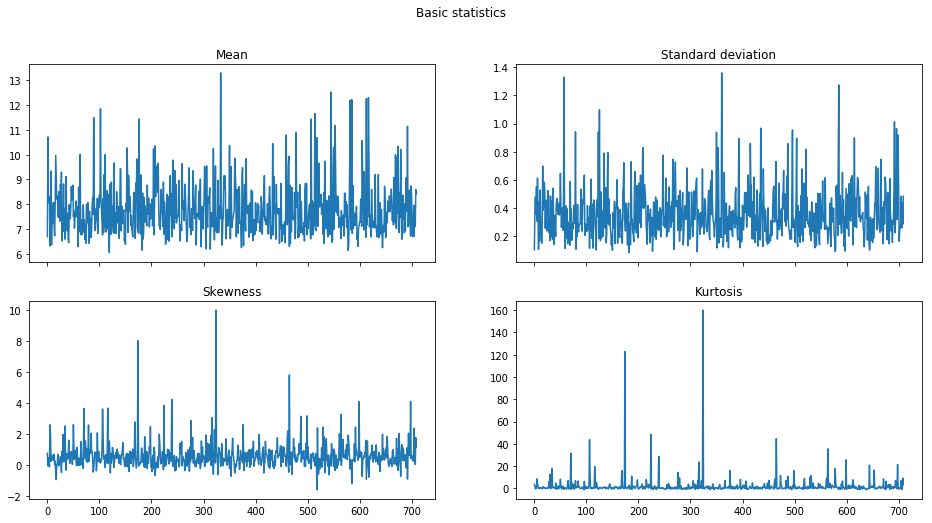

No normalization


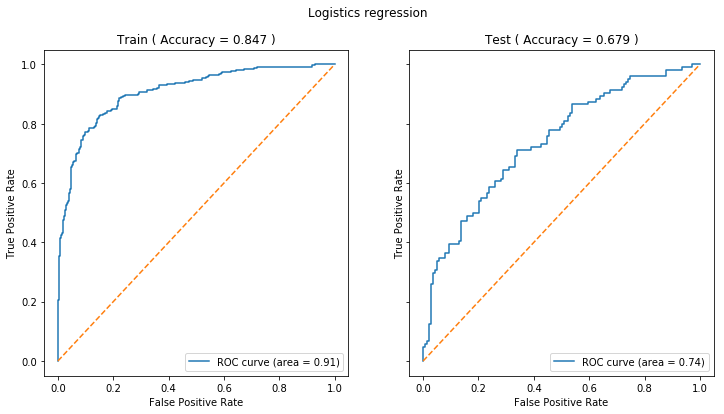

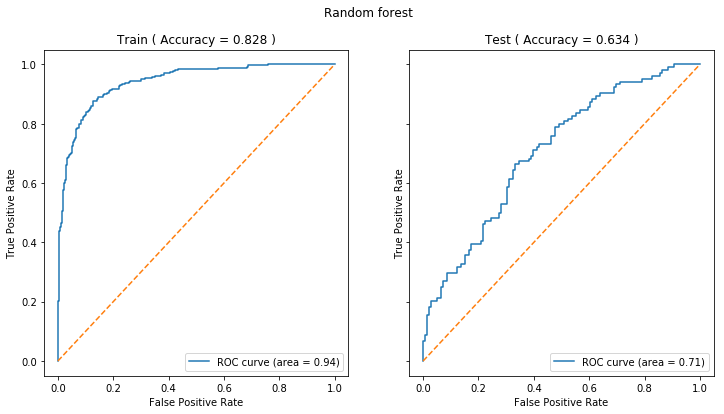

In [12]:
basic_insight(dataset_random2)